In [1]:
import parselmouth as pm
import numpy as np
from fasttrackpy.tracks import OneTrack, CandidateTracks
import polars as pl
import matplotlib.pyplot as plt
from scipy.fft import dct, idct

In [2]:
def dct_reg(x, order=5, orthoganalize = True, norm = "backward"):
    """get dct coefficients with regression"""
    y = np.array(x)
    N = x.size
    basis = dct(np.eye(N), orthogonalize=orthoganalize, norm = norm)[:,0:order]
    coefs = np.dot(
        np.linalg.inv(
            np.dot(
                basis.T,
                basis
            )
        ),
        np.dot(
            basis.T,
            y
        )
    )
    return coefs


def dct_reg_fit(coefs, order = 5, size = 100, orthoganalize = True, norm = "backward"):
    """get dct fit"""
    basis = dct(np.eye(size), orthogonalize=orthoganalize, norm = norm)[:,0:order].T
    fit = np.dot(basis.T, coefs)
    return fit

In [3]:
sound = pm.Sound("assets/ay.wav")

In [4]:
candidates = CandidateTracks(
    sound = sound,
    min_max_formant=4000,
    max_max_formant=6000,
    window_length=0.025
)

In [5]:
f1 = candidates.to_df()["F1"].to_numpy()

In [6]:
def fit_all(
        y,
        order = 5, 
        size = 100, 
        orthoganalize = True, 
        norms = ["backward", "forward"]):
    coefs = dct_reg(
        y,
        order = order, 
        orthoganalize=orthoganalize,
        norm = norms[0]
    )
    reg_fit = dct_reg_fit(
        coefs, order = order, size = y.size, orthoganalize=orthoganalize, norm = norms[0]
    )
    reg_fit_short = dct_reg_fit(
        coefs, order = coefs.size, size = 100, 
        orthoganalize=orthoganalize, norm = norms[0]
    )

    idct_fit = idct(
        coefs,
        n = f1.size,
        orthogonalize=orthoganalize,
        norm = norms[1]
        )
    
    idct_fit_short = idct(
        coefs,
        n = 100,
        orthogonalize=orthoganalize,
        norm = norms[1]
        )
    
    long_df = pl.DataFrame({
        "reg_fit": reg_fit,
        "idct_fit": idct_fit
    })

    short_df = pl.DataFrame({
        "reg_fit": reg_fit_short,
        "idct_fit": idct_fit_short
    })

    return (long_df, short_df)

In [7]:
def plot_fit(
        y,
        order = 5, 
        size = 100, 
        orthoganalize = True, 
        norms = ["backward", "forward"]):
    long_df, short_df = fit_all(y, order = order, orthoganalize=orthoganalize,
                                size = size, norms = norms)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.plot(long_df)
    ax1.legend(["smooth", "idct"])
    ax1.set_title("long basis")
    ax2.plot(short_df)
    ax2.legend(["smooth", "idct"])
    ax2.set_title("short basis")
    plt.suptitle(f"orth: {orthoganalize}, norm: {norms}")

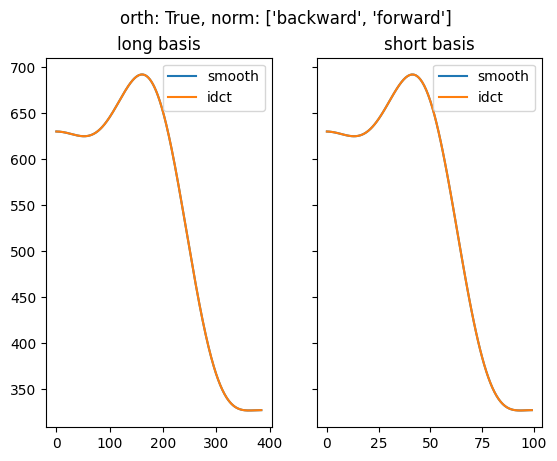

In [8]:
plot_fit(
    f1,
    orthoganalize=True,
    norms=["backward", "forward"]
)

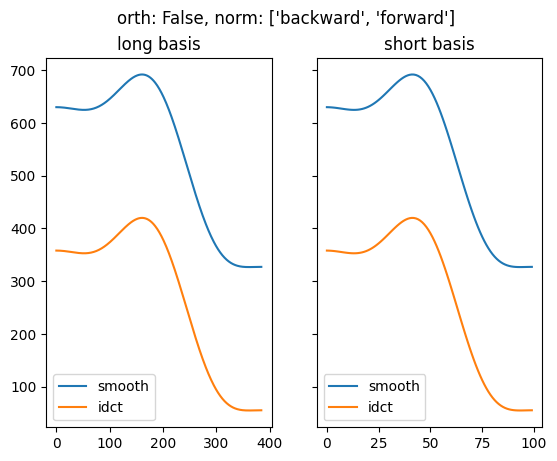

In [9]:
plot_fit(
    f1,
    orthoganalize=False,
    norms=["backward", "forward"]
)

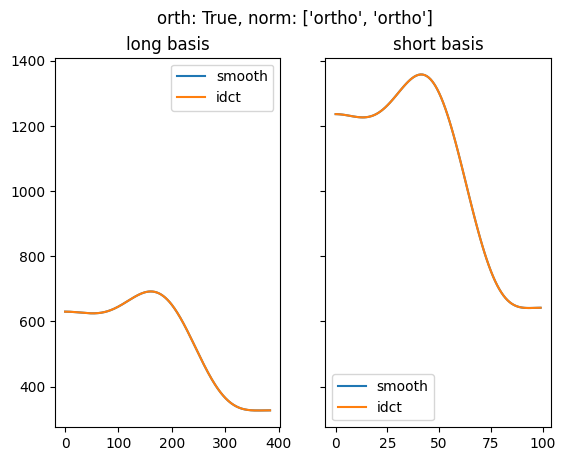

In [10]:
plot_fit(
    f1,
    orthoganalize=True,
    norms=["ortho", "ortho"]
)

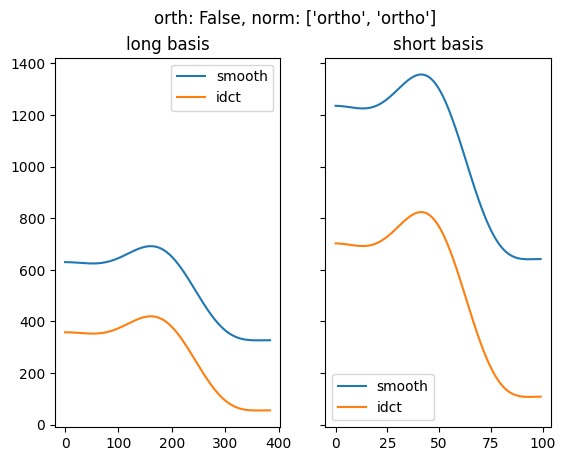

In [11]:
plot_fit(
    f1,
    orthoganalize=False,
    norms=["ortho", "ortho"]
)